In [2]:
import torch
checkpoint = torch.load('Models/robust.pt')

In [3]:
from robustness.model_utils import make_and_restore_model
from robustness.datasets import ImageNet

model, _ = make_and_restore_model(arch='resnet50', dataset=ImageNet('/imagenet/'), resume_path='Models/robust.pt')
model.eval()


=> loading checkpoint 'Models/robust.pt'
=> loaded checkpoint 'Models/robust.pt' (epoch 11)


AttackerModel(
  (normalizer): InputNormalize()
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): SequentialWithArgs(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)

# Dataset class

In [4]:
import json

images_info = None

with open('Data/COCO17/annotations/captions_train2017.json', 'r') as f:
  images_info = json.load(f)

file_name_to_id = dict()

for image_info in images_info['images']:
    file_name_to_id[image_info['file_name']] = image_info['id']
    
captions_dict = None

with open('Data/COCO17/cap_dict.json', 'r') as f:
  captions_dict = json.load(f)


In [40]:
from torch.utils.data import Dataset
import os
import glob
from PIL import Image
import PIL
import torchvision.transforms as transforms

class MyDataset(Dataset):
    def __init__(self, root):
        self.image_files = glob.glob(os.path.join(root, "*.jpg"))

    def __getitem__(self, index):
        image_file = self.image_files[index]
        image = PIL.Image.open(image_file)
        image = image.convert('RGB')
        file_name = image_file.split('/')[-1]
        image_tensor = transforms.ToTensor()(image)

        return image_tensor, file_name_to_id[file_name]

    def __len__(self):
        return len(self.image_files)

# Gradcam

In [27]:
!pwd

/media/external_10TB/10TB/Behnamnia/AttentionRL


In [28]:
from torchvision.models import *
from efficientnet_pytorch import EfficientNet
import glob
import matplotlib.pyplot as plt
import numpy as np
import torch 
import PIL.Image
import cv2


from torchvision.transforms import ToTensor, Resize, Compose, ToPILImage
%cd A-journey-into-Convolutional-Neural-Network-visualization-
from visualisation.core.utils import device 
from visualisation.core.utils import image_net_postprocessing


from visualisation.core import *
from visualisation.core.utils import image_net_preprocessing


# for animation
%matplotlib inline
from IPython.display import Image
from matplotlib.animation import FuncAnimation
from collections import OrderedDict

import torch
from torchvision.models import resnet101
# from torchvision.models.feature_extraction import get_graph_node_names
# from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models.detection.mask_rcnn import MaskRCNN
from torchvision.models.detection.backbone_utils import LastLevelMaxPool
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork

/media/external_10TB/10TB/Behnamnia/AttentionRL/A-journey-into-Convolutional-Neural-Network-visualization-


In [30]:
%cd ..

/media/external_10TB/10TB/Behnamnia/AttentionRL


In [31]:
from torchvision import transforms
from torch import nn

class Resnet101GradCam(torch.nn.Module):
  def __init__(self, patch_size = (64, 64)):
      super(Resnet101GradCam, self).__init__()
      feature_extractor = resnet101(pretrained=True).to(device).eval()
      self.vis = GradCam(feature_extractor, device)
      self.patch_size = patch_size
      self.conv_mean = nn.Conv2d(1, 1, kernel_size=self.patch_size, stride=self.patch_size, padding=0,  bias=False)
      self.conv_mean.weight = torch.nn.Parameter(torch.ones_like(self.conv_mean.weight)  / (patch_size[0] * patch_size[1]))


  def forward(self, x, h, w):
      self.vis(x, None, postprocessing=image_net_postprocessing)[0]
      self.vis.cam -= torch.min(self.vis.cam)
      self.vis.cam /= torch.max(self.vis.cam)
      resized_cam = transforms.Resize(size=(h, w))(self.vis.cam.unsqueeze(0).unsqueeze(0))

      number_of_rows = (h - 1) // self.patch_size[0] + 1
      number_of_cols = (w - 1) // self.patch_size[1] + 1

      scores = self.conv_mean(resized_cam)

      softmax = nn.Softmax()
      
      choice = torch.multinomial(scores.flatten(), 1).item()

      row_choice, col_choice = choice // number_of_cols, choice % number_of_cols

      return torch.tensor([[row_choice, col_choice]])

# Environment

In [32]:
from enum import Enum

class Actions(Enum):
    STAY = 0
    UP = 1
    RIGHT = 2
    DOWN = 3
    LEFT = 4

In [33]:
from scipy.stats import ks_2samp

class Envitronment():
  def __init__(self, dataloader, device, patch_size=(64, 64), input_size=224):
    self.dataloader = dataloader
    self.iterator = iter(dataloader)
    self.grad = Resnet101GradCam(patch_size).to(device).eval()
    self.transform = transforms.Resize(input_size)
    self.patch_size = patch_size
    self.device = device
    self.reset()

  def reset(self):
    
    try:
        # Samples the batch
        self.current_image, self.image_id = next(self.iterator)
        
    except StopIteration:
        # restart the iterator if the previous iterator is exhausted.
        self.iterator = iter(self.dataloader)
        self.current_image, self.image_id = next(self.iterator)
    
    self.current_image = self.current_image.to(self.device)
    self.image_id = str(self.image_id.item())
    _, _, self.height, self.width = self.current_image.shape
    self.captions = captions_dict[self.image_id]
    self.row, self.col = [int(x) for x in self.grad(self.transform(self.current_image), self.height, self.width)[0]]
    self.calculate_patch_histograms()


  def calculate_patch_histograms(self):
    max_row, max_col = self.height // self.patch_size[0], self.width // self.patch_size[1]

    self.histograms = []

    for i in range(max_row):
      self.histograms.append([])
      for j in range(max_col):
          start_row, end_row = i * self.patch_size[0], (i + 1) * self.patch_size[0]
          start_col, end_col = j * self.patch_size[1], (j + 1) * self.patch_size[1]

          selected_patch = self.current_image[:, :, start_row: end_row, start_col: end_col].detach().clone()

          hue = self.rgb2h(selected_patch).cpu()
          self.histograms[-1].append(np.histogram(hue, bins=10, range=(0., 1.), density=True)[0])


  def measure_similarity(self):
    current_patch_histogram = self.histograms[self.row][self.col]
    max_row, max_col = self.height // self.patch_size[0], self.width // self.patch_size[1]
    similarity_matrix = []

    for i in range(max_row):
      similarity_matrix.append([])
      for j in range(max_col):
        p_value = ks_2samp(current_patch_histogram,  self.histograms[i][j]).pvalue
        similarity_matrix[-1].append(p_value)

    return similarity_matrix

  def get_patch(self):
    start_row, end_row = self.row * self.patch_size[0], (self.row + 1) * self.patch_size[0]
    start_col, end_col = self.col * self.patch_size[1], (self.col + 1) * self.patch_size[1]
    return self.current_image[:, :, start_row: end_row, start_col: end_col]
  
  def step(self, action):
    if action == Actions.UP:
      self.row = self.row - 1
    elif action == Actions.RIGHT:
      self.col = self.col + 1
    elif action == Actions.DOWN:
      self.row = self.row + 1
    elif action == Actions.LEFT:
      self.col = self.col - 1
    else:
      pass #TODO STAY

    return self.get_patch()

  def visualize(self, alpha=0.4):
    start_row, end_row = self.row * self.patch_size[0], (self.row + 1) * self.patch_size[0]
    start_col, end_col = self.col * self.patch_size[1], (self.col + 1) * self.patch_size[1]

    mask = torch.zeros_like(self.current_image)
    mask[:, :, start_row: end_row, start_col: end_col] = 1

    return alpha * mask + (1 - alpha) * self.current_image
  
  def rgb2h(self, rgb: torch.Tensor) -> torch.Tensor:
    cmax, cmax_idx = torch.max(rgb, dim=1, keepdim=True)
    cmin = torch.min(rgb, dim=1, keepdim=True)[0]
    delta = cmax - cmin
    hsv_h = torch.empty_like(rgb[:, 0:1, :, :])
    cmax_idx[delta == 0] = 3
    hsv_h[cmax_idx == 0] = (((rgb[:, 1:2] - rgb[:, 2:3]) / delta) % 6)[cmax_idx == 0]
    hsv_h[cmax_idx == 1] = (((rgb[:, 2:3] - rgb[:, 0:1]) / delta) + 2)[cmax_idx == 1]
    hsv_h[cmax_idx == 2] = (((rgb[:, 0:1] - rgb[:, 1:2]) / delta) + 4)[cmax_idx == 2]
    hsv_h[cmax_idx == 3] = 0.
    hsv_h /= 6.
    hsv_s = torch.where(cmax == 0, torch.tensor(0.).type_as(rgb), delta / cmax)
    hsv_v = cmax
    return hsv_h

In [34]:
from transformers import GPT2Tokenizer, GPT2Model, GPT2Config
import torch
import torch.nn as nn
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
config = GPT2Config(vocab_size = 5000, n_positions = 64, n_embd = 256, n_layer = 6, n_head = 8, bos_token_id = 3, eos_token_id = 2, add_cross_attention=True)
model = GPT2Model(config)

x = model(encoder_hidden_states=torch.ones(3, 20, 256), input_ids=torch.tensor([[3, 7], [3, 8], [3, 9]])) #TODO _ID_GENERATION For Sequential Caption Generation

In [37]:
dataset = MyDataset(root="Data/COCO17/train2017/")
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [41]:
env = Envitronment(dataloader, device)

/media/external_10TB/10TB/Behnamnia/AttentionRL/rl_env/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/media/external_10TB/10TB/Behnamnia/AttentionRL/rl_env/lib/python3.6/site-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [42]:
env.height, env.width

(429, 640)

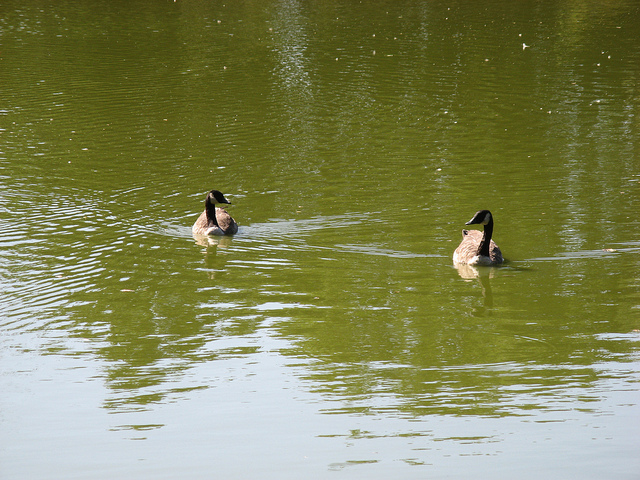

In [44]:
env.reset()
image = env.current_image
pil_image = transforms.ToPILImage()(image[0])
display(pil_image)

In [46]:
env.row, env.col

(2, 3)

In [45]:
env.captions

['two ducks are swimming outdoors in the water',
 'a couple of ducks floating on top of a lake',
 'two ducks swimming alongside each other in a pond',
 'a couple of geese wading in some pond water',
 'a pond with two ducks laying in the water and looking at each other']

0 3


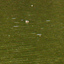

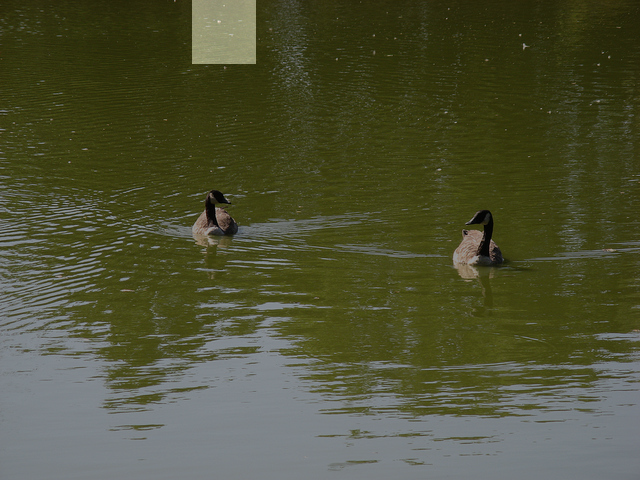

0 4


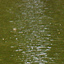

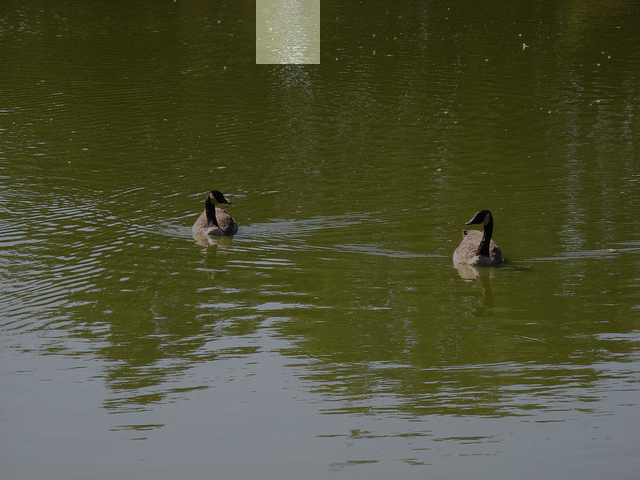

1 4


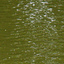

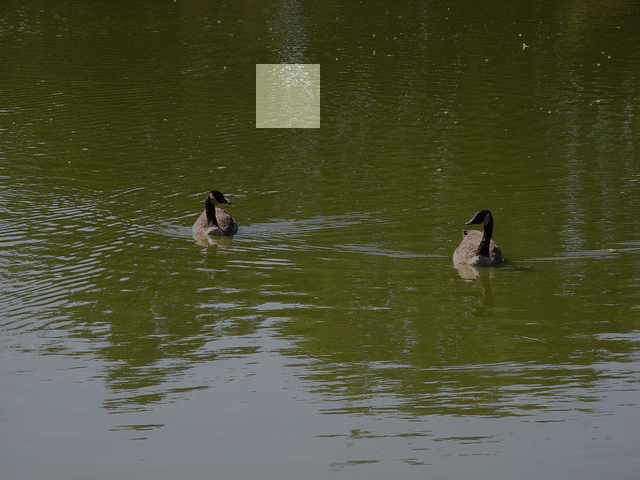

1 3


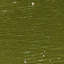

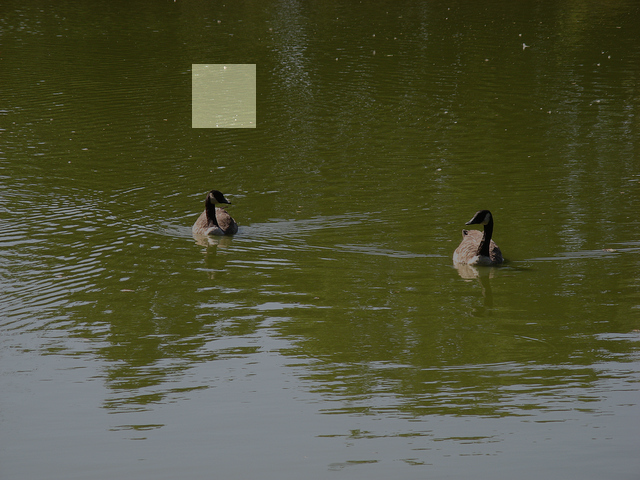

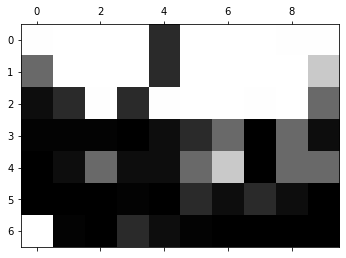

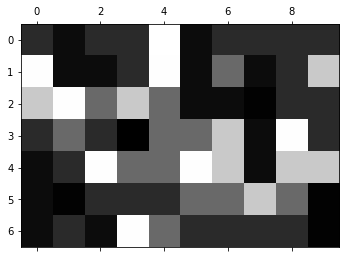

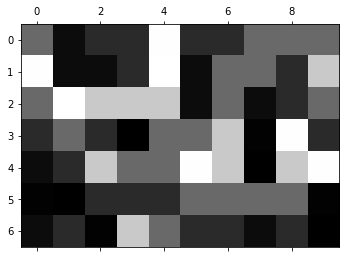

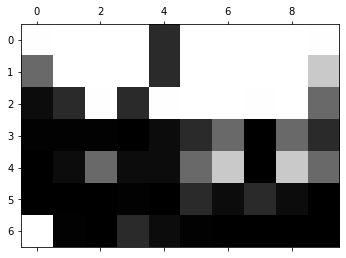

In [48]:
steps = [Actions.UP, Actions.RIGHT, Actions.DOWN, Actions.LEFT]
for step in steps:
  patch = env.step(step)
  print(env.row, env.col)
  display(transforms.ToPILImage()(patch[0]))
  display(transforms.ToPILImage()(env.visualize()[0]))
  plt.matshow(env.measure_similarity(), cmap='gray')

# RL

## Feature Extractor

In [54]:
import torchvision
print(torchvision.__version__)

0.10.0+cu102


In [53]:
from torchvision.models import resnet50


In [52]:
from torchvision.models import ResNet50_Weights

ImportError: cannot import name 'ResNet50_Weights'

In [55]:

feature_extractor_model = resnet50()
feature_extractor_model.eval()
feature_extractor_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [56]:
SAVE_MODELS = True  # Save models to file so you can test later
MODEL_PATH = "./RL_network/pong-cnn-"  # Models path for saving or loading
SAVE_MODEL_INTERVAL = 10  # Save models at every X epoch
TRAIN_MODEL = True  # Train model while playing (Make it False when testing a model)

LOAD_MODEL_FROM_FILE = False  # Load model from file
LOAD_FILE_EPISODE = 0  # Load Xth episode from file

BATCH_SIZE = 64  # Minibatch size that select randomly from mem for train nets
MAX_EPISODE = 100000  # Max episode
MAX_STEP = 100000  # Max step size for one episode

MAX_MEMORY_LEN = 50000  # Max memory len
MIN_MEMORY_LEN = 40000  # Min memory len before start train

GAMMA = 0.97  # Discount rate
ALPHA = 0.00025  # Learning rate
EPSILON_DECAY = 1 #.99  # Epsilon decay rate by step

RENDER_GAME_WINDOW = False  # Opens a new window to render the game (Won't work on colab default)

In [57]:
class DuelCNN(nn.Module):
  
    def __init__(self, output_size, feature_extractor_model):
        super(DuelCNN, self).__init__()
        self.feature_extractor = feature_extractor_model
        linear_input_size = 1000 #convw * convh * 64  # Last conv layer's out sizes
        

        # self.conv1 = nn.Conv2d(in_channels=4,  out_channels=32, kernel_size=8, stride=4)
        # self.bn1 = nn.BatchNorm2d(32)
        # convw, convh = self.conv2d_size_calc(w, h, kernel_size=8, stride=4)
        # self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        # self.bn2 = nn.BatchNorm2d(64)
        # convw, convh = self.conv2d_size_calc(convw, convh, kernel_size=4, stride=2)
        # self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)
        # self.bn3 = nn.BatchNorm2d(64)
        # convw, convh = self.conv2d_size_calc(convw, convh, kernel_size=3, stride=1)

        # Action layer
        self.Alinear1 = nn.Linear(in_features=linear_input_size, out_features=128)
        self.Alrelu = nn.LeakyReLU()  # Linear 1 activation funct
        self.Alinear2 = nn.Linear(in_features=128, out_features=output_size)

        # State Value layer
        self.Vlinear1 = nn.Linear(in_features=linear_input_size, out_features=128)
        self.Vlrelu = nn.LeakyReLU()  # Linear 1 activation funct
        self.Vlinear2 = nn.Linear(in_features=128, out_features=1)  # Only 1 node


    def forward(self, x):
        # x = F.relu(self.bn1(self.conv1(x)))
        # x = F.relu(self.bn2(self.conv2(x)))
        # x = F.relu(self.bn3(self.conv3(x)))

        x = self.feature_extractor(x)

        x = x.view(x.size(0), -1)  # Flatten every batch

        Ax = self.Alrelu(self.Alinear1(x))
        Ax = self.Alinear2(Ax)  # No activation on last layer

        Vx = self.Vlrelu(self.Vlinear1(x))
        Vx = self.Vlinear2(Vx)  # No activation on last layer

        q = Vx + (Ax - Ax.mean())

        return q


    # def conv2d_size_calc(self, w, h, kernel_size=5, stride=2):
    #     """
    #     Calcs conv layers output image sizes
    #     """
    #     next_w = (w - (kernel_size - 1) - 1) // stride + 1
    #     next_h = (h - (kernel_size - 1) - 1) // stride + 1
    #     return next_w, next_h

In [58]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from collections import deque
import time

In [60]:
class Agent:
    def __init__(self, environment):
        """
        Hyperparameters definition for Agent
        """
        # State size for breakout env. SS images (210, 160, 3). Used as input size in network
        self.state_size_h = 64 #environment.observation_space.shape[0]
        self.state_size_w = 64 #environment.observation_space.shape[1]
        self.state_size_c = 3 #environment.observation_space.shape[2]

        # Activation size for breakout env. Used as output size in network
        self.action_size = 5 #environment.action_space.n

        # Image pre process params
        # self.target_h = 80  # Height after process
        # self.target_w = 64  # Widht after process

        # self.crop_dim = [20, self.state_size_h, 0, self.state_size_w]  # Cut 20 px from top to get rid of the score table

        # Trust rate to our experiences
        self.gamma = GAMMA  # Discount coef for future predictions
        self.alpha = ALPHA  # Learning Rate

        # After many experinces epsilon will be 0.05
        # So we will do less Explore more Exploit
        self.epsilon = 1  # Explore or Exploit
        self.epsilon_decay = EPSILON_DECAY  # Adaptive Epsilon Decay Rate
        self.epsilon_minimum = 0.05  # Minimum for Explore

        # Deque holds replay mem.
        self.memory = deque(maxlen=MAX_MEMORY_LEN)

        # Create two model for DDQN algorithm
        self.online_model = DuelCNN(output_size=self.action_size, feature_extractor_model= feature_extractor_model).to(DEVICE)
        self.target_model = DuelCNN(output_size=self.action_size, feature_extractor_model= feature_extractor_model).to(DEVICE)
        self.target_model.load_state_dict(self.online_model.state_dict())
        self.target_model.eval()

        # Adam used as optimizer
        self.optimizer = optim.Adam(self.online_model.parameters(), lr=self.alpha)

    # def preProcess(self, image):
    #     """
    #     Process image crop resize, grayscale and normalize the images
    #     """
    #     # frame = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # To grayscale
    #     # frame = frame[self.crop_dim[0]:self.crop_dim[1], self.crop_dim[2]:self.crop_dim[3]]  # Cut 20 px from top
    #     # frame = cv2.resize(frame, (self.target_w, self.target_h))  # Resize
    #     frame = image.reshape(self.target_w, self.target_h) / 255  # Normalize

    #     return frame

    def act(self, state):
        """
        Get state and do action
        Two option can be selectedd if explore select random action
        if exploit ask nnet for action
        use epsilon greedy algorithm
        """

        act_protocol = 'Explore' if random.uniform(0, 1) <= self.epsilon else 'Exploit'

        if act_protocol == 'Explore':
            action = random.randrange(self.action_size)
        else:
            with torch.no_grad():
                # state = torch.tensor(state, dtype=torch.float, device=DEVICE).unsqueeze(0)
                q_values = self.online_model.forward(state)  # (1, action_size)
                action = torch.argmax(q_values).item()  # Returns the indices of the maximum value of all elements

        return action

    def train(self):
        """
        Train neural nets with replay memory
        returns loss and max_q val predicted from online_net
        """
        if len(agent.memory) < MIN_MEMORY_LEN:
            loss, max_q = [0, 0]
            return loss, max_q
        # We get out minibatch and turn it to numpy array
        state, action, reward, next_state, done = zip(*random.sample(self.memory, BATCH_SIZE))

        # Concat batches in one array
        # (np.arr, np.arr) ==> np.BIGarr
        state = np.concatenate(state)
        next_state = np.concatenate(next_state)

        # Convert them to tensors
        state = torch.tensor(state, dtype=torch.float, device=DEVICE)
        next_state = torch.tensor(next_state, dtype=torch.float, device=DEVICE)
        action = torch.tensor(action, dtype=torch.long, device=DEVICE)
        reward = torch.tensor(reward, dtype=torch.float, device=DEVICE)
        done = torch.tensor(done, dtype=torch.float, device=DEVICE)

        # Make predictions
        state_q_values = self.online_model(state)
        next_states_q_values = self.online_model(next_state)
        next_states_target_q_values = self.target_model(next_state)

        # Find selected action's q_value
        selected_q_value = state_q_values.gather(1, action.unsqueeze(1)).squeeze(1)
        # Get indice of the max value of next_states_q_values
        # Use that indice to get a q_value from next_states_target_q_values
        # We use greedy for policy So it called off-policy
        next_states_target_q_value = next_states_target_q_values.gather(1, next_states_q_values.max(1)[1].unsqueeze(1)).squeeze(1)
        # Use Bellman function to find expected q value
        expected_q_value = reward + self.gamma * next_states_target_q_value * (1 - done)

        # Calc loss with expected_q_value and q_value
        loss = (selected_q_value - expected_q_value.detach()).pow(2).mean()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss, torch.max(state_q_values).item()

    def storeResults(self, state, action, reward, nextState, done):
        """
        Store every result to memory
        """
        self.memory.append([state[None, :], action, reward, nextState[None, :], done])

    def adaptiveEpsilon(self):
        """
        Adaptive Epsilon means every step
        we decrease the epsilon so we do less Explore
        """
        if self.epsilon > self.epsilon_minimum:
            self.epsilon *= self.epsilon_decay

In [ ]:
environment = Envitronment(dataloader, device)
agent = Agent(environment)  # Create Agent

if LOAD_MODEL_FROM_FILE:
    agent.online_model.load_state_dict(torch.load(MODEL_PATH+str(LOAD_FILE_EPISODE)+".pkl"))

    with open(MODEL_PATH+str(LOAD_FILE_EPISODE)+'.json') as outfile:
        param = json.load(outfile)
        agent.epsilon = param.get('epsilon')

    startEpisode = LOAD_FILE_EPISODE + 1

else:
    startEpisode = 1

last_100_ep_reward = deque(maxlen=100)  # Last 100 episode rewards
total_step = 1  # Cumulkative sum of all steps in episodes
for episode in range(startEpisode, MAX_EPISODE):

    startTime = time.time()  # Keep time
    state = environment.reset()  # Reset env

    # state = agent.preProcess(state)  # Process image

    # Stack state . Every state contains 4 time contionusly frames
    # We stack frames like 4 channel image

    # TODO
    # state = np.stack((state, state, state, state))

    total_max_q_val = 0  # Total max q vals
    total_reward = 0  # Total reward for each episode
    total_loss = 0  # Total loss for each episode
    for step in range(MAX_STEP):

        if RENDER_GAME_WINDOW:
            plt.imshow(env.render(mode='rgb_array'), aspect='auto')
            plt.show()  # Show state visually

        # Select and perform an action
        action = agent.act(state)  # Act
        next_state = environment.step(action)  # Observe
        reward, done, info = 0, False, None


        display(transforms.ToPILImage()(state[0]))
        # next_state = agent.preProcess(next_state)  # Process image

        # Stack state . Every state contains 4 time contionusly frames
        # We stack frames like 4 channel image
        #TODO
        # next_state = np.stack((next_state, state[0], state[1], state[2]))

        # Store the transition in memory
        agent.storeResults(state, action, reward, next_state, done)  # Store to mem

        # Move to the next state
        state = next_state  # Update state

        if TRAIN_MODEL:
            # Perform one step of the optimization (on the target network)
            loss, max_q_val = agent.train()  # Train with random BATCH_SIZE state taken from mem
        else:
            loss, max_q_val = [0, 0]

        total_loss += loss
        total_max_q_val += max_q_val
        total_reward += reward
        total_step += 1
        if total_step % 1000 == 0:
            agent.adaptiveEpsilon()  # Decrase epsilon

        if done:  # Episode completed
            currentTime = time.time()  # Keep current time
            time_passed = currentTime - startTime  # Find episode duration
            current_time_format = time.strftime("%H:%M:%S", time.gmtime())  # Get current dateTime as HH:MM:SS
            epsilonDict = {'epsilon': agent.epsilon}  # Create epsilon dict to save model as file

            if SAVE_MODELS and episode % SAVE_MODEL_INTERVAL == 0:  # Save model as file
                weightsPath = MODEL_PATH + str(episode) + '.pkl'
                epsilonPath = MODEL_PATH + str(episode) + '.json'

                torch.save(agent.online_model.state_dict(), weightsPath)
                with open(epsilonPath, 'w') as outfile:
                    json.dump(epsilonDict, outfile)

            if TRAIN_MODEL:
                agent.target_model.load_state_dict(agent.online_model.state_dict())  # Update target model

            last_100_ep_reward.append(total_reward)
            avg_max_q_val = total_max_q_val / step

            outStr = "Episode:{} Time:{} Reward:{:.2f} Loss:{:.2f} Last_100_Avg_Rew:{:.3f} Avg_Max_Q:{:.3f} Epsilon:{:.2f} Duration:{:.2f} Step:{} CStep:{}".format(
                episode, current_time_format, total_reward, total_loss, np.mean(last_100_ep_reward), avg_max_q_val, agent.epsilon, time_passed, step, total_step
            )

            print(outStr)

            if SAVE_MODELS:
                outputPath = MODEL_PATH + "out" + '.txt'  # Save outStr to file
                with open(outputPath, 'a') as outfile:
                    outfile.write(outStr+"\n")

            break

PATCH = (k, k)
GAMMA = Discount factor
n_step = 

1. DDQN 
2. State (patch) -> (patch-3, patch-2, patch-1, patch0) - LSTM - (9->1, patch)
3. Reward = (traversed or not)*(-1) + (patch grad cam) * 1 + (states > 10) * -1

S -> Network_train -> (Qs(s), V(s))
